# `0x0E.Time Series Forecasting - Forecast Bitcoin`

---




import of library




In [91]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as K



In [45]:
# Extract dataframe from csv
coinbase_df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip')
print(coinbase_df.shape)
coinbase_df.head()

(2099760, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:

coinbase_df.describe()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.099760e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06
mean,1.483899e+09,3.246403e+03,3.247829e+03,3.244856e+03,3.246403e+03,7.849139e+00,3.600157e+04,3.246341e+03
std,3.638214e+07,3.799154e+03,3.801394e+03,3.796761e+03,3.799150e+03,1.873222e+01,1.401879e+05,3.799078e+03
min,1.417412e+09,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08,2.641700e-06,6.000000e-02
25%,1.452410e+09,4.195800e+02,4.196400e+02,4.195000e+02,4.195700e+02,9.024000e-01,6.440031e+02,4.195645e+02
50%,1.483906e+09,1.014580e+03,1.014890e+03,1.014150e+03,1.014530e+03,2.692900e+00,3.695642e+03,1.014512e+03
75%,1.515402e+09,6.322630e+03,6.324010e+03,6.321090e+03,6.322670e+03,7.600965e+00,1.972392e+04,6.322550e+03
max,1.546899e+09,1.989199e+04,1.989199e+04,1.989198e+04,1.989199e+04,1.563267e+03,1.997076e+07,1.989199e+04


Dealing with missing values

In [47]:
print(coinbase_df.isna().sum())
df = coinbase_df.dropna()
print('-----------------------------')
df.isna().sum()

Timestamp                 0
Open                 109069
High                 109069
Low                  109069
Close                109069
Volume_(BTC)         109069
Volume_(Currency)    109069
Weighted_Price       109069
dtype: int64
-----------------------------


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [48]:
#encode the date
df['date'] = [datetime.datetime.utcfromtimestamp(x) for x in df['Timestamp']]
date_time = pd.to_datetime(df.pop('Timestamp'), unit='s')
date = date_time.map(datetime.datetime.timestamp)

#date = pd.to_datetime(df.pop('Timestamp'), format='%d.%m.%Y %H:%M:%S')
df['date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0         2014-12-01 05:33:00
7         2014-12-01 05:40:00
51        2014-12-01 06:24:00
77        2014-12-01 06:50:00
1436      2014-12-02 05:29:00
                  ...        
2099755   2019-01-07 22:02:00
2099756   2019-01-07 22:03:00
2099757   2019-01-07 22:04:00
2099758   2019-01-07 22:05:00
2099759   2019-01-07 22:06:00
Name: date, Length: 1990691, dtype: datetime64[ns]

In [49]:

df = df[df['date'] >= '2016']
df = df[0::60]
#df.pop('Timestamp')
# date_time = date_time[0::60]
# date_time
df['date']
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
511553,430.35,430.39,430.35,430.39,0.0727,31.288653,430.380371,2016-01-01 00:00:00
511614,430.59,430.61,430.59,430.61,2.6285,1131.832543,430.600169,2016-01-01 01:01:00
511679,430.73,430.73,430.67,430.67,3.0312,1305.498362,430.686976,2016-01-01 02:06:00
511743,430.82,430.82,430.82,430.82,0.2777,119.638714,430.820000,2016-01-01 03:10:00
511812,434.80,434.81,434.80,434.81,0.3501,152.226881,434.809714,2016-01-01 04:19:00


In [8]:
# Droping none relevant features
df.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)



In [50]:


#Split the data
#(80%, 15%, 5%) split for the training, validation, and test sets.
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]

# Min-Max normalization 
train_df = (train_df-train_df.min())/(train_df.max()-train_df.min())
val_df = (val_df-val_df.min())/(val_df.max()-val_df.min())
test_df = (test_df-test_df.min())/(test_df.max()-test_df.min())
train_df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
511553,0.00390341,0.00386919,0.0039259,0.00386919,0.000132921,7.05047e-06,0.0039146,0.000000
511614,0.00391573,0.00388047,0.00393821,0.00388047,0.00480678,0.000255517,0.00392588,0.000048
511679,0.00392291,0.00388663,0.00394231,0.00388355,0.0055432,0.000294725,0.00393033,0.000099
511743,0.00392752,0.00389125,0.00395,0.00389125,0.00050781,2.6997e-05,0.00393715,0.000149
511812,0.00413167,0.00409591,0.00415415,0.00409591,0.00064021,3.43544e-05,0.0041418,0.000203
...,...,...,...,...,...,...,...,...
1788206,0.362409,0.362393,0.362424,0.362393,0.00050028,0.000458271,0.362416,0.999812
1788266,0.361871,0.361847,0.361881,0.361843,0.000829816,0.000759045,0.361873,0.999859
1788326,0.364733,0.36471,0.364747,0.36471,0.0096161,0.00886221,0.364739,0.999906
1788386,0.369606,0.369583,0.36962,0.369583,0.00118558,0.00110654,0.369612,0.999953


In [51]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [52]:
# Split to window
# -----------------------------------------------------------------------------
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [56]:
w2 = WindowGenerator(input_width=24,
    label_width=1,
    shift=1,
    label_columns=['Weighted_Price'])

example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 25, 8)
Inputs shape: (3, 24, 8)
labels shape: (3, 1, 1)


In [58]:
# Build datasets
# -----------------------------------------------------------------------------

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



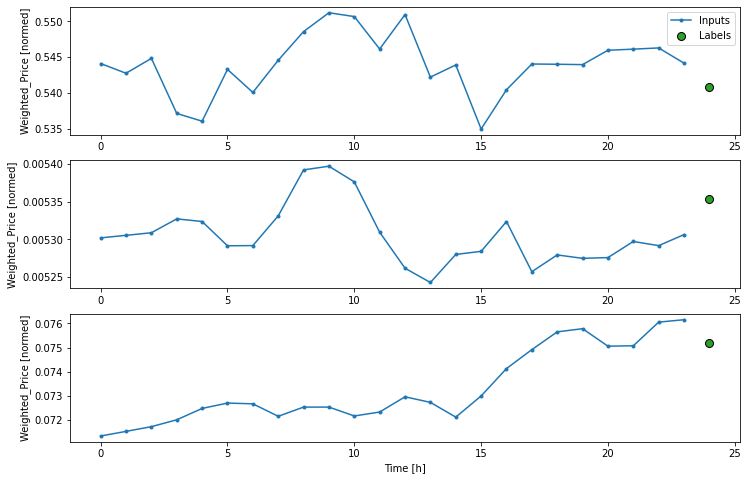

In [85]:
def plot(self, model=None, plot_col='Weighted_Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    # * train_std + train_mean,
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

WindowGenerator.plot = plot
w2.plot()


In [86]:


# Compile and fit model
# -----------------------------------------------------------------------------
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history



In [61]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [87]:
# Build RNN module using LSTM Gate

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [92]:
# history = compile_and_fit(lstm_model, w2)
# val_performance = {}
# performance = {}
# # IPython.display.clear_output()
# val_performance['LSTM'] = lstm_model.evaluate(w2.val)
# performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)

history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)


121/121 [==============================] - 1s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0346


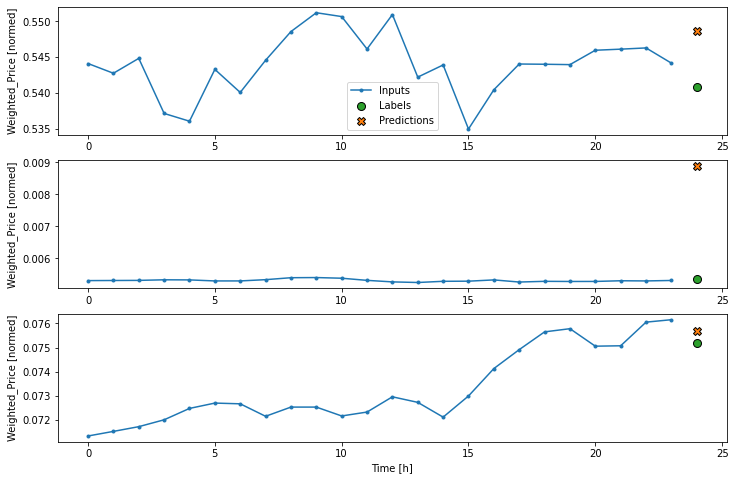

In [93]:
w2.plot(lstm_model)


All shapes are: (batch, time, features)
Window shape: (3, 25, 8)
Inputs shape: (3, 24, 8)
labels shape: (3, 1, 1)


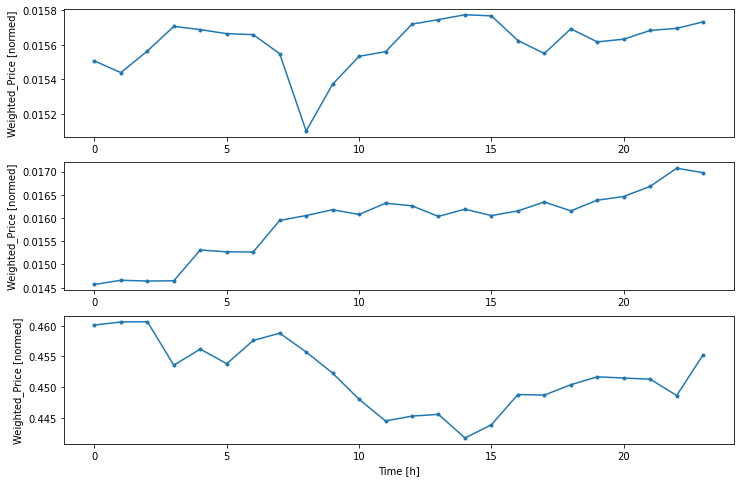

In [67]:
w3 = WindowGenerator(input_width=24,
    label_width=1,
    shift=1,
    label_columns=['Close'])

example_window = tf.stack([np.array(train_df[:w3.total_window_size]),
                           np.array(train_df[100:100+w3.total_window_size]),
                           np.array(train_df[200:200+w3.total_window_size])])


example_inputs, example_labels = w3.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
WindowGenerator.plot = plot
w3.plot()

In [79]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Weighted_Price'])
single_step_window
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


baseline = Baseline(label_index=single_step_window.column_indices['Weighted_Price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)



122/122 [==============================] - 1s 3ms/step - loss: 1.6275e-04 - mean_absolute_error: 0.0067


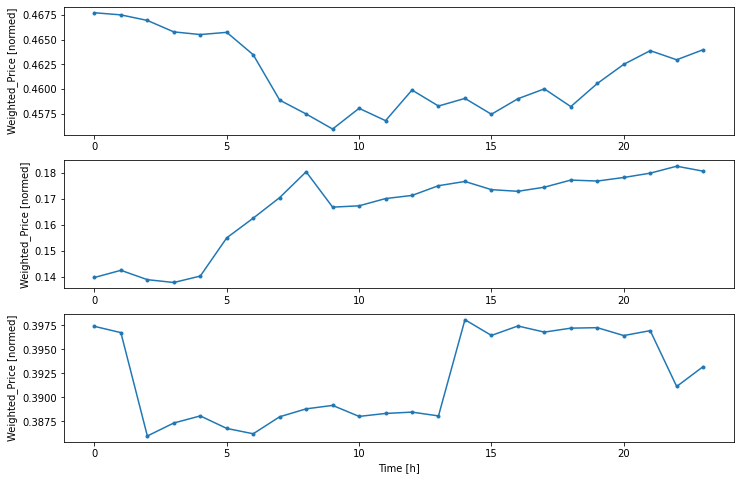

In [84]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Open'])

wide_window.plot(baseline)



In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
